In [5]:
!pip install surprise

     |████████████████████████████████| 6.5MB 3.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678220 sha256=bba6f9dba411b6abdd8c5032341905c508e997f26b9ecc09280290363768f1b9
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import packages
import numpy as np 
import pandas as pd 
import os 
from matplotlib import pyplot as plt
import warnings
import time
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

from surprise.dataset import Dataset
from surprise.similarities import pearson
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import BaselineOnly

from surprise import Reader
from surprise.model_selection.split import KFold, train_test_split
from surprise.accuracy import mse, rmse
from sklearn import metrics

In [0]:
data_directory = r'/content/gdrive/My Drive/Colab/ml-latest-small'
os.chdir(data_directory)

# links = pd.read_csv('links.csv')
# movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv') # only movie rating is used in this project
tags = pd.read_csv('tags.csv') # used for movie genre

num_movie = len(ratings['movieId'].unique())
num_user = len(ratings['userId'].unique())

# create rating matrix R
matrix = coo_matrix((ratings.rating.to_list(), (ratings.userId.to_list(), ratings.movieId.to_list()))).toarray()
R = pd.DataFrame(index = range(611), columns= ratings['movieId'].unique(), data = matrix[:, ratings.movieId.unique()])
R = R.drop(R.index[0])
R.replace(0, np.nan, inplace = True)

#### Matrix Factorization with Bias (MF with Bias)

In [0]:
# prepare data
file_path = os.path.expanduser(r'/content/gdrive/My Drive/Colab/ml-latest-small/ratings.csv')
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

# count the number of ratings for each movie
movie_rate_frequency = pd.DataFrame(index = ratings.movieId.unique(), data = num_user - R.isna().sum(axis = 0))
movie_rate_frequency = movie_rate_frequency.sort_values(by = 0, ascending=False)

# compute the rating variance of each movie
movie_rate_var = pd.DataFrame(index = ratings.movieId.unique(), data = R.var(axis = 0))
movie_rate_var.replace(np.nan, 0, inplace = True)

# prepare trimmed movieId
movie_frevar = pd.DataFrame(index = ratings.movieId.unique())
movie_frevar['frequency'] = num_user - R.isna().sum(axis = 0)
movie_frevar['variance'] = R.var(axis = 0)
popular_movieId = movie_rate_frequency[movie_frevar['frequency'] > 2].index.tolist()
popular_movieId = list(map(str, popular_movieId))

unpopular_movieId = movie_rate_frequency[movie_frevar['frequency'] <= 2].index.tolist()
unpopular_movieId = list(map(str, unpopular_movieId))

highvar_movieId = movie_rate_frequency[(movie_frevar['frequency'] >= 5) & (movie_frevar['variance'] >= 2)].index.tolist()
highvar_movieId = list(map(str, highvar_movieId))

In [0]:
class svd_kfold():
    def __init__(self, num_factors, data):
        self.model = SVD(n_factors = num_factors)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

$\textbf{Question 24}$: Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [14]:
# define number of factors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_24, mean_mae_24 = [], []

# perform k-fold cross validation 
for k in K:
    model = svd_kfold(num_factors = k, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_24.append(performance['mean_rmse'])
    mean_mae_24.append(performance['mean_mse'])

RMSE: 0.8556
MSE: 0.7320
RMSE: 0.8711
MSE: 0.7587
RMSE: 0.8542
MSE: 0.7297
RMSE: 0.8757
MSE: 0.7669
RMSE: 0.8804
MSE: 0.7751
RMSE: 0.8655
MSE: 0.7491
RMSE: 0.8678
MSE: 0.7531
RMSE: 0.8684
MSE: 0.7541
RMSE: 0.8679
MSE: 0.7533
RMSE: 0.8612
MSE: 0.7416
RMSE: 0.8693
MSE: 0.7557
RMSE: 0.8543
MSE: 0.7298
RMSE: 0.8763
MSE: 0.7679
RMSE: 0.8675
MSE: 0.7525
RMSE: 0.8682
MSE: 0.7538
RMSE: 0.8736
MSE: 0.7632
RMSE: 0.8622
MSE: 0.7434
RMSE: 0.8608
MSE: 0.7410
RMSE: 0.8735
MSE: 0.7629
RMSE: 0.8614
MSE: 0.7419
RMSE: 0.8698
MSE: 0.7566
RMSE: 0.8775
MSE: 0.7700
RMSE: 0.8767
MSE: 0.7686
RMSE: 0.8524
MSE: 0.7266
RMSE: 0.8568
MSE: 0.7341
RMSE: 0.8560
MSE: 0.7328
RMSE: 0.8723
MSE: 0.7609
RMSE: 0.8673
MSE: 0.7523
RMSE: 0.8521
MSE: 0.7260
RMSE: 0.8771
MSE: 0.7694
RMSE: 0.8626
MSE: 0.7441
RMSE: 0.8674
MSE: 0.7524
RMSE: 0.8697
MSE: 0.7564
RMSE: 0.8660
MSE: 0.7499
RMSE: 0.8680
MSE: 0.7534
RMSE: 0.8640
MSE: 0.7466
RMSE: 0.8603
MSE: 0.7402
RMSE: 0.8666
MSE: 0.7509
RMSE: 0.8607
MSE: 0.7408
RMSE: 0.8793
MSE: 0.7733


0.8543064253417695
0.7298394683802323
1
1


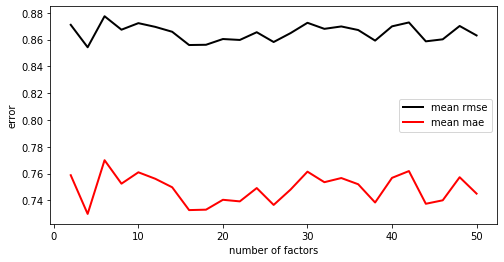

In [15]:
print(min(mean_rmse_24))
print(min(mean_mae_24))
print(np.argmin(mean_rmse_24))
print(np.argmin(mean_mae_24))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_24, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_24, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 25}$: Use the plot from question 24, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.

$\textbf{Question 26}$: Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [17]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_26, mean_mae_26 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_26.append(performance['mean_rmse'])
    mean_mae_26.append(performance['mean_mse'])

RMSE: 0.8569
MSE: 0.7342
RMSE: 0.8788
MSE: 0.7723
RMSE: 0.8682
MSE: 0.7538
RMSE: 0.8651
MSE: 0.7485
RMSE: 0.8490
MSE: 0.7208
RMSE: 0.8517
MSE: 0.7254
RMSE: 0.8490
MSE: 0.7208
RMSE: 0.8593
MSE: 0.7383
RMSE: 0.8551
MSE: 0.7312
RMSE: 0.8650
MSE: 0.7482
RMSE: 0.8531
MSE: 0.7278
RMSE: 0.8564
MSE: 0.7334
RMSE: 0.8608
MSE: 0.7410
RMSE: 0.8629
MSE: 0.7446
RMSE: 0.8743
MSE: 0.7644
RMSE: 0.8594
MSE: 0.7386
RMSE: 0.8491
MSE: 0.7209
RMSE: 0.8619
MSE: 0.7429
RMSE: 0.8522
MSE: 0.7263
RMSE: 0.8609
MSE: 0.7412
RMSE: 0.8476
MSE: 0.7185
RMSE: 0.8626
MSE: 0.7441
RMSE: 0.8641
MSE: 0.7467
RMSE: 0.8578
MSE: 0.7358
RMSE: 0.8579
MSE: 0.7360
RMSE: 0.8457
MSE: 0.7152
RMSE: 0.8606
MSE: 0.7406
RMSE: 0.8748
MSE: 0.7653
RMSE: 0.8557
MSE: 0.7323
RMSE: 0.8699
MSE: 0.7567
RMSE: 0.8610
MSE: 0.7413
RMSE: 0.8591
MSE: 0.7380
RMSE: 0.8692
MSE: 0.7555
RMSE: 0.8631
MSE: 0.7450
RMSE: 0.8616
MSE: 0.7424
RMSE: 0.8657
MSE: 0.7495
RMSE: 0.8506
MSE: 0.7235
RMSE: 0.8553
MSE: 0.7316
RMSE: 0.8499
MSE: 0.7224
RMSE: 0.8607
MSE: 0.7408


0.8410869443449591
0.7074272479475403


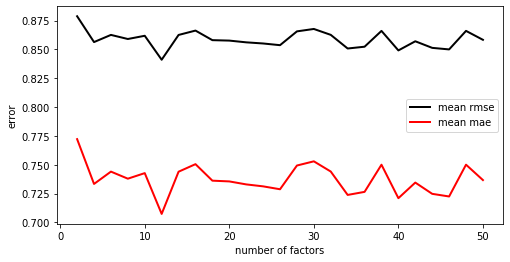

In [18]:
print(min(mean_rmse_26))
print(min(mean_mae_26))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_26, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_26, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 27}$: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [21]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_27, mean_mae_27 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k,data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_27.append(performance['mean_rmse'])
    mean_mae_27.append(performance['mean_mse'])

RMSE: 0.9713
MSE: 0.9434
RMSE: 0.9966
MSE: 0.9932
RMSE: 0.9210
MSE: 0.8482
RMSE: 0.9856
MSE: 0.9715
RMSE: 0.9755
MSE: 0.9517
RMSE: 0.9518
MSE: 0.9059
RMSE: 0.9658
MSE: 0.9328
RMSE: 0.9922
MSE: 0.9844
RMSE: 1.0037
MSE: 1.0073
RMSE: 0.9521
MSE: 0.9066
RMSE: 0.9240
MSE: 0.8537
RMSE: 0.9828
MSE: 0.9658
RMSE: 1.0080
MSE: 1.0161
RMSE: 0.9761
MSE: 0.9528
RMSE: 1.0108
MSE: 1.0218
RMSE: 0.9996
MSE: 0.9992
RMSE: 0.9757
MSE: 0.9520
RMSE: 0.9352
MSE: 0.8747
RMSE: 0.9510
MSE: 0.9044
RMSE: 0.9638
MSE: 0.9289
RMSE: 0.9694
MSE: 0.9397
RMSE: 0.9838
MSE: 0.9678
RMSE: 1.0256
MSE: 1.0519
RMSE: 0.9824
MSE: 0.9651
RMSE: 0.9588
MSE: 0.9193
RMSE: 0.9758
MSE: 0.9521
RMSE: 0.9574
MSE: 0.9166
RMSE: 0.9338
MSE: 0.8720
RMSE: 0.9570
MSE: 0.9159
RMSE: 1.0395
MSE: 1.0805
RMSE: 0.9922
MSE: 0.9844
RMSE: 0.9785
MSE: 0.9574
RMSE: 1.0255
MSE: 1.0517
RMSE: 0.9423
MSE: 0.8880
RMSE: 0.9977
MSE: 0.9953
RMSE: 0.9162
MSE: 0.8394
RMSE: 0.9927
MSE: 0.9854
RMSE: 0.9662
MSE: 0.9335
RMSE: 1.0018
MSE: 1.0036
RMSE: 0.9737
MSE: 0.9481


0.9271348537695873
0.859579037074354


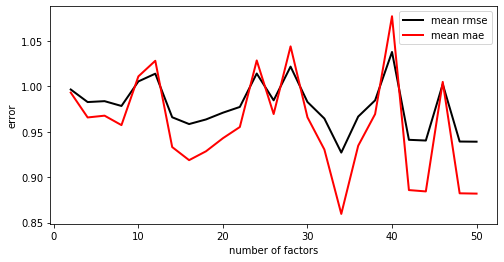

In [22]:
print(min(mean_rmse_27))
print(min(mean_mae_27))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_27, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_27, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 28}$: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [24]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_28, mean_mae_28 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k,  data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = highvar_movieId)
    mean_rmse_28.append(performance['mean_rmse'])
    mean_mae_28.append(performance['mean_mse'])


RMSE: 1.3732
MSE: 1.8856
RMSE: 1.4008
MSE: 1.9623
RMSE: 1.3897
MSE: 1.9312
RMSE: 1.4308
MSE: 2.0472
RMSE: 1.1836
MSE: 1.4009
RMSE: 1.2610
MSE: 1.5900
RMSE: 1.5376
MSE: 2.3644
RMSE: 1.3366
MSE: 1.7864
RMSE: 1.4055
MSE: 1.9754
RMSE: 1.2701
MSE: 1.6131
RMSE: 1.3798
MSE: 1.9039
RMSE: 1.3040
MSE: 1.7005
RMSE: 1.3338
MSE: 1.7790
RMSE: 1.5329
MSE: 2.3498
RMSE: 1.3824
MSE: 1.9111
RMSE: 1.3712
MSE: 1.8801
RMSE: 1.2182
MSE: 1.4841
RMSE: 1.3329
MSE: 1.7766
RMSE: 1.4203
MSE: 2.0171
RMSE: 1.4218
MSE: 2.0216
RMSE: 1.4257
MSE: 2.0327
RMSE: 1.3872
MSE: 1.9243
RMSE: 1.1656
MSE: 1.3586
RMSE: 1.5649
MSE: 2.4489
RMSE: 1.3427
MSE: 1.8027
RMSE: 1.3529
MSE: 1.8302
RMSE: 1.4937
MSE: 2.2312
RMSE: 1.1989
MSE: 1.4374
RMSE: 1.1559
MSE: 1.3361
RMSE: 1.3361
MSE: 1.7852
RMSE: 1.4460
MSE: 2.0909
RMSE: 1.5834
MSE: 2.5072
RMSE: 1.3520
MSE: 1.8279
RMSE: 1.5972
MSE: 2.5510
RMSE: 1.2142
MSE: 1.4743
RMSE: 1.2420
MSE: 1.5426
RMSE: 1.4926
MSE: 2.2278
RMSE: 1.4096
MSE: 1.9868
RMSE: 1.2526
MSE: 1.5691
RMSE: 1.1465
MSE: 1.3145


1.20783653022206
1.458869083738865


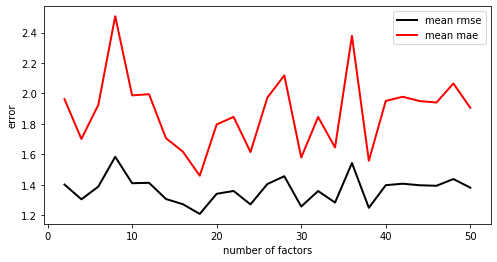

In [25]:
print(min(mean_rmse_28))
print(min(mean_mae_28))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_28, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_28, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()


$\textbf{Question 29}$: Plot the ROC curves for the MF with bias collaborative filter designed in question 24 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 25. For each of the plots, also report the area under the curve (AUC) value.


The roc areas of the 4 thresholds are [0.7996821252348949, 0.7873291703983812, 0.7843557110139378, 0.7801965630715897] , respectively


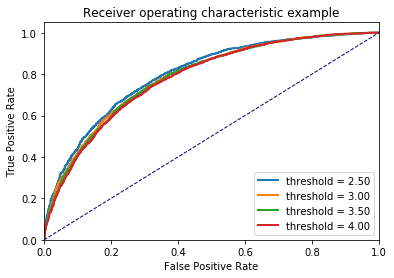

In [27]:
# use k = 12 from problem 17
model_29 = SVD(n_factors = 3)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_29.fit(data_train)
test_pred_29 = model_29.test(data_test)

# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred_29[p][3] for p in range(len(test_pred_29))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)
    
for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')
